In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv("FLIGHTS.csv")
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,index
0,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",700,707.0,7.0,0.0,0.0,950.0,15.0,1.0,1.0,0.0,NaN,95.0,103.0,619.0,7.0,0.0,8.0,0.0,0.0,0
1,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",1830,1826.0,0.0,0.0,-1.0,2112.0,2.0,0.0,0.0,0.0,NaN,100.0,106.0,619.0,0.0,0.0,0.0,0.0,0.0,1
2,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10800,1080003,"Burbank, CA",1420,1426.0,6.0,0.0,0.0,1516.0,0.0,0.0,-1.0,0.0,NaN,130.0,110.0,672.0,0.0,0.0,0.0,0.0,0.0,2
3,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10821,1082106,"Baltimore, MD",1500,1514.0,14.0,0.0,0.0,2050.0,15.0,1.0,1.0,0.0,NaN,215.0,216.0,1670.0,14.0,0.0,1.0,0.0,0.0,3
4,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",11259,1125904,"Dallas, TX",530,527.0,0.0,0.0,-1.0,805.0,0.0,0.0,-1.0,0.0,NaN,105.0,98.0,580.0,0.0,0.0,0.0,0.0,0.0,4


In [5]:
df_completed = df[df['CANCELLED'] == 0] # Use non cancelled flights + base off of departure delay not arrival delay
df_completed.shape

(7444080, 32)

In [6]:
df_completed['HOUR'] = df_completed['CRS_DEP_TIME'] // 100 
df_completed.head()

/var/folders/h1/w_jtl0654ns96y8ngd075fj40000gn/T/ipykernel_2546/1921052717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completed['HOUR'] = df_completed['CRS_DEP_TIME'] // 100


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,index,HOUR
0,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",700,707.0,7.0,0.0,0.0,950.0,15.0,1.0,1.0,0.0,NaN,95.0,103.0,619.0,7.0,0.0,8.0,0.0,0.0,0,7
1,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",1830,1826.0,0.0,0.0,-1.0,2112.0,2.0,0.0,0.0,0.0,NaN,100.0,106.0,619.0,0.0,0.0,0.0,0.0,0.0,1,18
2,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10800,1080003,"Burbank, CA",1420,1426.0,6.0,0.0,0.0,1516.0,0.0,0.0,-1.0,0.0,NaN,130.0,110.0,672.0,0.0,0.0,0.0,0.0,0.0,2,14
3,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10821,1082106,"Baltimore, MD",1500,1514.0,14.0,0.0,0.0,2050.0,15.0,1.0,1.0,0.0,NaN,215.0,216.0,1670.0,14.0,0.0,1.0,0.0,0.0,3,15
4,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",11259,1125904,"Dallas, TX",530,527.0,0.0,0.0,-1.0,805.0,0.0,0.0,-1.0,0.0,NaN,105.0,98.0,580.0,0.0,0.0,0.0,0.0,0.0,4,5


In [7]:
REGION_MAP = {
    # West
    "CA":"West","OR":"West","WA":"West","NV":"West","ID":"West","UT":"West",
    "AZ":"West","NM":"West","CO":"West","MT":"West","WY":"West","AK":"West","HI":"West",
    # Midwest
    "IL":"Midwest","IN":"Midwest","MI":"Midwest","OH":"Midwest","WI":"Midwest",
    "MN":"Midwest","IA":"Midwest","MO":"Midwest","ND":"Midwest","SD":"Midwest","NE":"Midwest","KS":"Midwest",
    # Northeast
    "NY":"Northeast","NJ":"Northeast","PA":"Northeast","MA":"Northeast","CT":"Northeast",
    "RI":"Northeast","NH":"Northeast","VT":"Northeast","ME":"Northeast","DC":"Northeast",
    # Southeast
    "FL":"Southeast","GA":"Southeast","NC":"Southeast","SC":"Southeast",
    "VA":"Southeast","WV":"Southeast","TN":"Southeast","AL":"Southeast","MS":"Southeast","KY":"Southeast",
    # Southwest
    "TX":"Southwest","OK":"Southwest","AR":"Southwest","LA":"Southwest","NM":"West"
}

# --- Extract the 2-letter state abbreviation from ORIGIN_CITY_NAME (e.g., "Austin, TX") ---
state_pat = re.compile(r",\s*([A-Z]{2})\b")

def extract_state(city_name: str) -> str:
    if pd.isna(city_name):
        return None
    m = state_pat.search(city_name)
    return m.group(1) if m else None

# Apply to ORIGIN_CITY_NAME
df_completed["state"] = df_completed["ORIGIN_CITY_NAME"].apply(extract_state)

# Map state -> region
df_completed["region"] = df_completed["state"].map(REGION_MAP).fillna("Other")

/var/folders/h1/w_jtl0654ns96y8ngd075fj40000gn/T/ipykernel_2546/2412098412.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completed["state"] = df_completed["ORIGIN_CITY_NAME"].apply(extract_state)
/var/folders/h1/w_jtl0654ns96y8ngd075fj40000gn/T/ipykernel_2546/2412098412.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completed["region"] = df_completed["state"].map(REGION_MAP).fillna("Other")


In [8]:
# Should we do different clusters based on different profiles or do them all together?? 

cluster_features = [
    "MONTH", # Average delay minutes varies by month (per Edward and Elena's eda)
    "HOUR", # Edwards plot 
    "MKT_CARRIER_AIRLINE_ID", # Very clear clusters of airline sizes based off of Chloe's eda
    "ORIGIN_AIRPORT_ID", # Same as above per Chloe's eda
    "DEST_AIRPORT_ID", # Want to avoid using arrival info, but whatever
    "region", # Has a correlation sorta with airline / origin airports? 
]

In [9]:
""" One Hot Encode categorical features and standarize continuous"""

cat_features = ["MKT_CARRIER_AIRLINE_ID", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "region"]
num_features = ["MONTH", "HOUR"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", StandardScaler(), num_features)
    ]
)

In [10]:
k = 3  # Start with this but should do elbow method??
kmeans = Pipeline([
    ("prep", preprocess),
    ("cluster", KMeans(n_clusters=k, random_state=42)) # Should I set the n_init value??
])

kmeans.fit(df_completed[cluster_features])
df_completed["cluster"] = kmeans.predict(df_completed[cluster_features])

/var/folders/h1/w_jtl0654ns96y8ngd075fj40000gn/T/ipykernel_2546/1538697732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completed["cluster"] = kmeans.predict(df_completed[cluster_features])


In [11]:
df_completed["cluster"].value_counts()

cluster
0    2611516
2    2471763
1    2360801
Name: count, dtype: int64

In [12]:
df_completed.groupby("cluster")["DEP_DELAY_NEW"].mean()

cluster
0    22.208954
1    11.235289
2    13.580750
Name: DEP_DELAY_NEW, dtype: float64

# Elbow Method

In [13]:
# X = preprocess.fit_transform(df_completed) # Tried running for 6 + minutes. Takes too long to run

# inertia = []
# k_range = range(2, 6)

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
#     kmeans.fit(X)
#     inertia.append(kmeans.inertia_)

# plt.figure()
# plt.plot(k_range, inertia, marker='o')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
# plt.title("Elbow Method for Flight Clustering")
# plt.show()

# Silhouette

In [14]:
# for k in range(2,6):
#     km = Pipeline([
#         ("prep", preprocess),
#         ("cluster", KMeans(n_clusters=k, random_state=42))
#     ])
#     km.fit(df_completed[cluster_features])
#     cluster_labels = km.predict(df_completed[cluster_features])
#     score = silhouette_score(
#         km.named_steps["prep"].transform(df_completed[cluster_features]),
#         cluster_labels
#     )
#     print(f"k={k}, silhouette={score:.4f}")

In [ ]:
pd.crosstab(df_completed["cluster"], df_completed["MKT_CARRIER_AIRLINE_ID"], normalize="index")

MKT_CARRIER_AIRLINE_ID,19393,19690,19790,19805,19930,19977,20368,20409,20416,20436
cluster,,,,,,,,,,
0,0.199228,0.007678,0.204187,0.266610,0.045790,0.165408,0.016294,0.026186,0.037734,0.030886
1,0.190742,0.008477,0.204896,0.265932,0.045443,0.183630,0.015933,0.027158,0.030181,0.027608
2,0.205198,0.008816,0.202393,0.257952,0.042999,0.177173,0.017626,0.028571,0.033000,0.026273
3,0.122862,0.025769,0.211968,0.176053,0.116556,0.215853,0.007428,0.064153,0.038989,0.020369


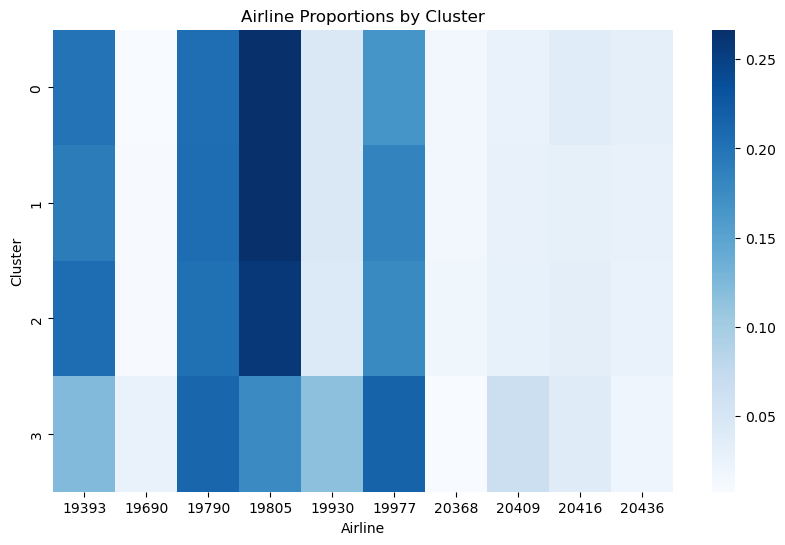

In [ ]:
ct = pd.crosstab(
    df_completed["cluster"], 
    df_completed["MKT_CARRIER_AIRLINE_ID"], 
    normalize="index"
)

plt.figure(figsize=(10,6))
sns.heatmap(ct, annot=False, cmap="Blues")
plt.title("Airline Proportions by Cluster")
plt.xlabel("Airline")
plt.ylabel("Cluster")
plt.show()

# Stacking 